# Классификация датасета MNIST с помощью PyTorch Lightning.

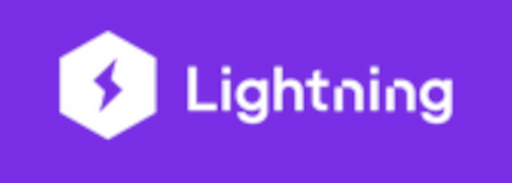

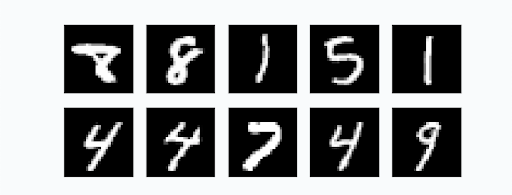

In [1]:
!pip install pytorch-lightning # По умолчанию Lightning не входит в шаблон виртуальной машины Colab и его нужно дополнительно устанавливать.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.1 MB/s eta 0:00:00


In [2]:
import os  # Для манипуляций с файлами

import torch
from torch import nn
from torch.nn import functional as F    # В пакете functional находятся некоторые ф-ции
from torch.utils.data import TensorDataset, DataLoader, random_split
                          # DataLoader - вспомогательный класс для загрузки данных. Одна из задач, решаемых им - это буферизация
                          # ввода-вывода. Аналог того, что происходит в Tensorflow при указании размера batch'a.
                          # random_split позволяет разделить данные как на обучающую-тестовую выборки, так и на
                          # обучающую-валидационную-тестовую.
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
                          # torchvision - отдельный пакет с инструментами для решения задач компьютерного зрения.
                          # Поскольку на PyTorch решаются много задач компьютерного зрения.
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
                          # callbacks - аналогично колбэкам в Keras для сохранения данных о модели: есть ModelCheckpoint для сохранения
                          # контрольных точек модели; есть EarlyStopping - для раннего останова обучения модели.

In [3]:
# Путь, куда сохранять параметры модели.
# Можно примонтировать Google Drive для сохранения результатов.
# Результаты останутся на Google Drive, если в Colab произойдет отключение от среды исполнения.
MODEL_PATH='drive/My Drive/4_classification_pytorch_mnist'  # Путь для сохранения параметров моделей.

In [4]:
def prepare_data():   # Оформим в виде метода ф-цию для подготовки данных.
    """
    Скачать датасет и создать обучающую, валидационную и тестовую выборки.
    """
    transform=transforms.Compose([     # Используем стандартное преобразование из PyTorch, которое преобразует наш датасет в тензоры.
            transforms.ToTensor(),
            # Иногда встречается рекомендация нормализовывать MNIST с такими значениями среднего и стандартного отклонения.
            transforms.Normalize((0.1307,), (0.3081,))  # Эту вещь можно делать, можно - нет
                                                        # transforms также содержит методы для нормализации данных.
    ])

    train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
                # os.getcwd() возвращает текущую директорию, которую мы передаем в MNIST в качестве целевой директории для скачивания
                # датасета.
                # train=True - флаг, указывающий на то, какой выборкой будет этот датасет: True - обучающей, False - тестовой.
    train = [train[i] for i in range(2200)]

    train, val = random_split(train, [2000, 200])   # Дополнительно делим нашу выборку еще на обучающую и валидационную.

    test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    test = [test[i] for i in range(3000,4000)]

    return train, val, test

In [5]:
class LightningMnistClassifier(pl.LightningModule):
    """
    Классификатор датасета MNIST с помощью PyTorch Lightning.
    """

    def __init__(self, lr_rate):
        super(LightningMnistClassifier, self).__init__()
          # Строим простую модель, состоящую из 3-ех линейных слоев:
        self.layer_1 = torch.nn.Linear(28 * 28, 128)   # 28*28 - задает размер входа первого слоя. В нашем случае - это размер изображения.
                                                       # 128  - выходное количество нейронов слоя.
        self.layer_2 = torch.nn.Linear(128, 256) # В каждом послеудющем слое, по сути, размер входа совпадает с размером выхода предыдущего.
        self.layer_3 = torch.nn.Linear(256, 10)  # И последний слой имеет 10 выходов - по количеству выделяемых классов.
        self.lr_rate = lr_rate

    def forward(self, x):  # Описывает прямое распространение по сети. Определяет соединение слоев, описанных в конструкторе выше.
        batch_size, channels, width, height = x.size()

        # (batch_size, 1, 28, 28) -> (batch_size, 1*28*28)
        x = x.view(batch_size, -1)

        # Каждый следующий слой выводит больше признаков.
        x = self.layer_1(x)
        x = torch.relu(x)

        # Каждый следующий слой выводит больше признаков.
        x = self.layer_2(x)
        x = torch.relu(x)

        # Определяет влияние признаков на вероятности принадлежности к определённому классу.
        x = self.layer_3(x)
        x = torch.softmax(x, dim=1)

        return x

    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

    def training_step(self, train_batch, batch_idx):  # Этот метод задается унаследованным pl.LightningModule
        x, y = train_batch
        logits = self.forward(x) # В PyTorch мы должны не забыть в опрделении каждого метода явно вызвать метод прямого
                                 # распространения сигнала forward(x).
                                 # logits - это результаты распространения сигнала по сети. Просто взяли такое название из первых нейронных
                                 # сетей.
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss)

        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def validation_step(self, val_batch, batch_idx):  # Этот метод задается унаследованным pl.LightningModule
        x, y = val_batch
        logits = self.forward(x)   # logits - это результаты распространения сигнала по нейронной сети.
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss)

        logs = {'val_loss': loss}
        return {'val_loss': loss, 'log': logs}

    def test_step(self, val_batch, batch_idx):  # Этот метод задается унаследованным pl.LightningModule
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('test_loss', loss)

        logs = {'test_loss': loss}
        return {'test_loss': loss}

    def test_epoch_end(self, outputs):   # Этот метод задается унаследованным pl.LightningModule
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):    # Этот метод задается унаследованным pl.LightningModule
                  # Этот метод определяет, как мы конфигурируем наши оптимизаторы для обучения нейронной сети.
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr_rate)
        lr_scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95),
                        'name': 'expo_lr'}  # Здесь задаются некоторые параметры оптимизатора, в нашем случае - Adam.
                        # ExponentialLR - ф-ция, которая оптимизирует шаг обучения.
        return [optimizer], [lr_scheduler]

In [6]:
train, val, test = prepare_data()

100%|██████████| 9912422/9912422 [00:00<00:00, 31585549.41it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24001524.44it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 9906862.28it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6840405.30it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [7]:
train_loader, val_loader, test_loader = DataLoader(train, batch_size=64), DataLoader(val, batch_size=64), DataLoader(test, batch_size=64)
# Чисто технический момент: полученные выборки надо обернуть в DataLoader. Имеено DataLoader решает задачи буферизации ввода - аналог
# batcha из Keras. Кэшируем наши выборки с некоторым размером batch_size.

In [8]:
model = LightningMnistClassifier(lr_rate=1e-3)

# Автоматическое досрочное прекращение процесса обучения если заданная метрика качества не уменьшается заданное время.
early_stopping = EarlyStopping('val_loss', mode='min', patience=5)
# Callback для сheckpoint'а после эпохи обучения с локальным минимумом или максимумом метрики качества.
checkpoint_callback = ModelCheckpoint(dirpath=MODEL_PATH, filename='{epoch}-{val_loss:.2f}',
                                      monitor='val_loss', mode='min', save_top_k=3)
           # Есть стандартные колбэки, которые просто вызываются, как здесь. Но можно также написать и свою функцию.
           # save_top_k=3   - указывает на то, что нужно сохранять 3 наилучших результата среди результатов после каждой эпохи обучения.
           # monitor='val_loss', mode='min'  - критерий оптимальности минимум ф-ции потерь.
   # Создается некоторая внешняя сущность trainer для обучения нашей модели.
trainer = pl.Trainer(max_epochs=30, callbacks=[early_stopping, checkpoint_callback], default_root_dir=MODEL_PATH)
   # default_root_dir=MODEL_PATH   - задает путь для сохранения модели.

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 2.6 K 
-----------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Предсказанное значение : [1]
Реальное значение : 1


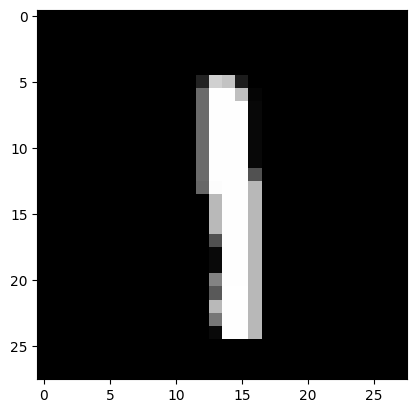

In [9]:
import numpy as np

test_pixels = test[3][0]
actual_label = test[3][1]

# Добавляем ещё одно измерение - batch size.
input = test_pixels.unsqueeze(1)

predictions = model(input)
print('Предсказанное значение :',np.argmax(predictions.detach().numpy(), axis=1))
print('Реальное значение :', actual_label)


import matplotlib.pyplot as plt

# Reshape - разворачиваем измерение, соответствующее каналам изображения (1 канал - оттенки серого).
plt.imshow(test_pixels.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

In [10]:
print(predictions)
print(type(predictions))

tensor([[7.6580e-13, 9.9840e-01, 2.3315e-08, 1.3569e-04, 1.1608e-08, 1.5379e-07,
         5.5977e-08, 2.0171e-06, 1.4583e-03, 6.7116e-07]],
       grad_fn=<SoftmaxBackward0>)
<class 'torch.Tensor'>


# Классификация датасета MNIST с помощью PyTorch Ignite.

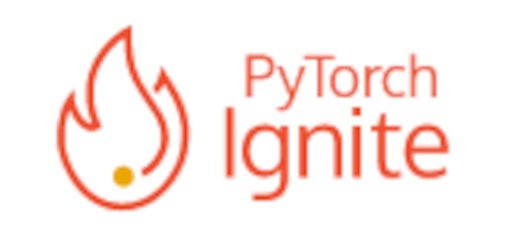

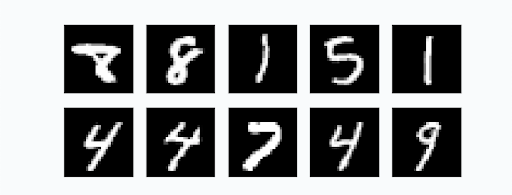

In [11]:
!pip install pytorch-ignite  # Тоже пакет по умолчанию не входит в Colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 6.8 MB/s eta 0:00:00


In [12]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor

from tqdm import tqdm  # Библиотека для отрисовки progress bar.

from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
     # Events - перечисление различных событий из жизненного цикла модели.
     # create_supervised_evaluator - валидатор для обучения с учителем.
     # create_supervised_trainer  - тренер для обучения с учителем.
from ignite.metrics import Accuracy, Loss
from ignite.utils import setup_logger  # Это просто удобный логгер, которым можно пользоваться, а можно и не пользоваться.
                                       # Можно его также написать самостоятельно.

In [13]:
class IgniteMnistClassifier(nn.Module):
    """
    Классификатор датасета MNIST с помощью PyTorch Ignite.
    """

    def __init__(self):
        super(IgniteMnistClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # Структура похожа на Keras
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # max_pool2d задается здес в виде функции. Но можно его также задать слоем.
                                                    # Получается, что вся структура модели размазана между конструктором и методам forward.
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)  # softmax  задан просто функцией.

In [14]:
def get_data_loaders(train_batch_size, val_batch_size):
    """
    Скачать датасет и создать обучающую и валидационную выборки.
    """

    data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    train_loader = DataLoader(
        MNIST(download=True, root=".", transform=data_transform, train=True), batch_size=train_batch_size
    )

    val_loader = DataLoader(
        MNIST(download=False, root=".", transform=data_transform, train=False), batch_size=val_batch_size
    )

    return train_loader, val_loader

In [15]:
# Запуск обучения и валидации.
# Разработчик модели должен написать подобный метод.
# За ним остаётся декомпозиция этого метода на вложенные методы, вынесение логики во вспомогательные классы и т.п.
# Ignite предоставляет только событийный механизм.
# Ignite в меньшей степени диктует организацию кода. У такого подхода есть и положительные, и отрицательные стороны.
def create_and_train_model(train_batch_size, val_batch_size, epochs, lr, momentum, log_interval) -> torch.nn.Module:
    """
    Создать и обучить модель.

    :return: обученная модель
    :rtype: torch.nn.Module
    """

    train_loader, val_loader = get_data_loaders(train_batch_size, val_batch_size)  # Оборачиваем наши выборки в data_loaders.
    model = IgniteMnistClassifier()  # Создаем модель.

    device = "cpu"
    if torch.cuda.is_available():   # Проверяем доступность CUDA
        device = "cuda"
    print(f"Using {device} device.")

    model.to(device)     # Явно отправляем вычисление модели на определенное устройство.
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.NLLLoss()
    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    trainer.logger = setup_logger("trainer")

    val_metrics = {"accuracy": Accuracy(), "nll": Loss(criterion)}
    evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)  # Создаем валидатор
    evaluator.logger = setup_logger("evaluator")

    # Например, можем сами добавить progress bar.
    # Эта строка задает вид вывода отдельной строки в таблице результатов после каждой эпохи обучения.
    with tqdm(initial=0, leave=False, total=len(train_loader), desc=f"ITERATION - loss: {0:.2f}") as progress_bar:
      trainer.run(train_loader, max_epochs=epochs)

    return model


    # Вложенные методы для привязки к событиям.
                 # Здесь начинает работать механизм Ignite - вызывем функции цикла обучения модели через декотраторы.
    @trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
    def log_training_loss(engine):
        progress_bar.desc = f"ITERATION - loss: {engine.state.output:.2f}"
        progress_bar.update(log_interval)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(engine):
        progress_bar.refresh()
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics
        avg_accuracy = metrics["accuracy"]
        avg_nll = metrics["nll"]
        tqdm.write(
            f"Training Results - Epoch: {engine.state.epoch} Avg accuracy: {avg_accuracy:.2f} Avg loss: {avg_nll:.2f}"
        )

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(engine):
        evaluator.run(val_loader)
        metrics = evaluator.state.metrics
        avg_accuracy = metrics["accuracy"]
        avg_nll = metrics["nll"]
        tqdm.write(
            f"Validation Results - Epoch: {engine.state.epoch} Avg accuracy: {avg_accuracy:.2f} Avg loss: {avg_nll:.2f}"
        )

        progress_bar.n = progress_bar.last_print_n = 0

    @trainer.on(Events.EPOCH_COMPLETED | Events.COMPLETED)
    def log_time(engine):
        tqdm.write(f"{trainer.last_event_name.name} took { trainer.state.times[trainer.last_event_name.name]} seconds")

In [16]:
# Запуск.
model = create_and_train_model(train_batch_size=32, val_batch_size=32, epochs=20, lr=0.01, momentum=0.5, log_interval=10)

Using cuda device.


ITERATION - loss: 0.00:   0%|          | 0/1875 [00:00<?, ?it/s]2023-05-05 15:09:00,374 trainer INFO: Engine run starting with max_epochs=20.
2023-05-05 15:09:28,792 trainer INFO: Epoch[1] Complete. Time taken: 00:00:28.416
2023-05-05 15:09:47,772 trainer INFO: Epoch[2] Complete. Time taken: 00:00:18.975
2023-05-05 15:10:06,212 trainer INFO: Epoch[3] Complete. Time taken: 00:00:18.438
2023-05-05 15:10:25,114 trainer INFO: Epoch[4] Complete. Time taken: 00:00:18.901
2023-05-05 15:10:43,379 trainer INFO: Epoch[5] Complete. Time taken: 00:00:18.264
2023-05-05 15:11:03,024 trainer INFO: Epoch[6] Complete. Time taken: 00:00:19.644
2023-05-05 15:11:20,825 trainer INFO: Epoch[7] Complete. Time taken: 00:00:17.800
2023-05-05 15:11:39,483 trainer INFO: Epoch[8] Complete. Time taken: 00:00:18.657
2023-05-05 15:11:57,193 trainer INFO: Epoch[9] Complete. Time taken: 00:00:17.709
2023-05-05 15:12:15,756 trainer INFO: Epoch[10] Complete. Time taken: 00:00:18.560
2023-05-05 15:12:34,488 trainer INFO:

Предсказанное значение : [9]
Реальное : 9


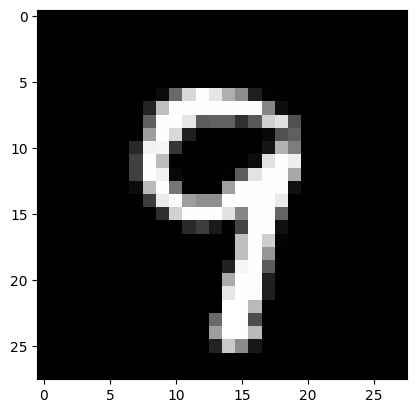

In [17]:
import numpy as np

test_pixels = test[8][0]
actual_label = test[8][1]

# Добавляем ещё одно измерение - batch size.
input = test_pixels.unsqueeze(1)

# Модель могла быть обучена не на CPU и находиться в RAM соответствующего устройства.
# Копируем её (вместе с обученными весовыми коэффициентами) обратно в основную RAM CPU, чтобы predictions вычислялись на CPU.
# В таком случае у модели будет доступ к данным test, которые находятся в RAM CPU.
# Другой вариант - скопировать данные в RAM устройства.
model.to("cpu")

predictions = model(input)
print('Предсказанное значение :',np.argmax(predictions.detach().numpy(), axis=1))
print('Реальное :', actual_label)


import matplotlib.pyplot as plt

# Reshape - разворачиваем измерение, соответствующее каналам изображения (1 канал - оттенки серого).
plt.imshow(test_pixels.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

In [18]:
print(predictions)
print(type(predictions))

tensor([[-3.2125e+01, -4.7014e+01, -3.6820e+01, -2.7874e+01, -2.5905e+01,
         -1.9952e+01, -4.3409e+01, -2.8732e+01, -9.6140e+00, -6.6755e-05]],
       grad_fn=<LogSoftmaxBackward0>)
<class 'torch.Tensor'>
